# Introduction

Machine learning has a phenomenal range of applications, including in health and diagnostics. This tutorial will explain the complete pipeline from loading data to predicting results, and it will explain how to build an X-ray image classification model from scratch to predict whether an X-ray scan shows presence of pneumonia. This is especially useful during these current times as COVID-19 is known to cause pneumonia.

**Follow the steps to download data from Kaggle 1st time**

Login in Kaggle and download the kaggle.json File from Kaggle settings.
**(One Time Activity)**

Click on the folder icon on left menu bar and upload the kaggle.json file.

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:28<00:00, 54.0MB/s]



Mount the Google Drive to move the downloaded zip file to google drive so that we don't have to download all the time

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Create a folder as per mentioned below directory
***Colab Notebooks/chest-xray-pneumonia/dataset***
Post that move the file using the below code

In [ ]:
mv '/content/chest-xray-pneumonia.zip' 'gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/dataset/'

 ---------------------------------------------------------------------

**Follow the below steps if you have the data zip file downloaded from kaggle in your gdrive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
mkdir /content/dataset/

In [ ]:
mkdir /content/dataset/fid

In [ ]:
mkdir /content/dataset/oid

In [ ]:
! unzip "gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/dataset/chest-xray-pneumonia" -d /content/dataset/oid

In [ ]:
mkdir /content/output

In [ ]:
mkdir /content/utils

In [ ]:
cp 'gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/utils/config.py' '/content/utils/config.py'

In [ ]:
cp 'gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/utils/conv_bc_model.py' '/content/utils/conv_bc_model.py'

In [ ]:
cp 'gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/utils/create_dataset.py' '/content/utils/create_dataset.py'

In [ ]:
cp 'gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/utils/getPaths.py' '/content/utils/getPaths.py'

In [ ]:
rm -rf /content/dataset/fid/chest_xray/__MACOSX

In [ ]:
rm -rf /content/dataset/fid/chest_xray/chest_xray

In [ ]:
mv '/content/dataset/oid/chest_xray/test' '/content/dataset/oid/'

In [ ]:
mv '/content/dataset/oid/chest_xray/train' '/content/dataset/oid/'

In [ ]:
mv '/content/dataset/oid/chest_xray/val' '/content/dataset/oid/'

In [ ]:
rm -rf '/content/dataset/oid/chest_xray'

In [ ]:
rm -rf '/content/dataset/oid/test/.ipynb_checkpoints'

In [ ]:
rm -rf '/content/dataset/oid/train/.ipynb_checkpoints'

In [ ]:
rm -rf '/content/dataset/oid/val/.ipynb_checkpoints'

In [ ]:
mv '/content/dataset/oid/train/NORMAL' '/content/dataset/oid/train/0'

In [ ]:
mv '/content/dataset/oid/train/PNEUMONIA' '/content/dataset/oid/train/1'

In [ ]:
mv '/content/dataset/oid/test/NORMAL' '/content/dataset/oid/test/0'

In [ ]:
mv '/content/dataset/oid/test/PNEUMONIA' '/content/dataset/oid/test/1'

In [ ]:
mv '/content/dataset/oid/val/NORMAL' '/content/dataset/oid/val/0'

In [ ]:
mv '/content/dataset/oid/val/PNEUMONIA' '/content/dataset/oid/val/1'

Running the Build Dataset file to shuffle and create the train test val folders and files

In [ ]:
! python /content/utils/create_dataset.py

-------------------------------------------------------------------------------

## Model Building and Evaluation

In [ ]:
# Mounting the google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# Google Drive Path
# gDrivePath = "gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/dataset/"

In [ ]:
# import sys
# sys.path.append(gDrivePath)

In [ ]:
# Setting the matplotlib backend so that if required then images can be saved in the background
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

In [ ]:
# Importing the libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from utils import config
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import cv2

In [ ]:
# pip install seaborn

In [ ]:
# Defining a function for plotting the count of data against each class in each directory
def plotData(dirPath):
    # Get the path to the normal and pneumonia sub-directories
    normal_cases_dir = dirPath+ '/0/'
    pneumonia_cases_dir = dirPath + '/1/'

    # Get the list of all the images
    normal_cases = glob.glob(normal_cases_dir + '*.jpeg')
    pneumonia_cases = glob.glob(pneumonia_cases_dir + '*.jpeg')

    # An empty list. We will insert the data into this list in (img_path, label) format
    data1 = []

    # Go through all the normal cases. The label for these cases will be 0
    for img in normal_cases:
        data1.append((img,0))

    # Go through all the pneumonia cases. The label for these cases will be 1
    for img in pneumonia_cases:
        data1.append((img, 1))

    # Get a pandas dataframe from the data we have in our list 
    data1 = pd.DataFrame(data1, columns=['image', 'label'],index=None)

    # Shuffle the data 
    data1 = data1.sample(frac=1.).reset_index(drop=True)
    
    
    
    # Get the counts for each class
    cases_count = data1['label'].value_counts()
    print(cases_count)

    # Plot the results 
    plt.figure(figsize=(10,8))
    sns.barplot(x=cases_count.index, y= cases_count.values)
    plt.title('Number of cases', fontsize=14)
    plt.xlabel('Case type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
    plt.show()

1    3052
0    1164
Name: label, dtype: int64


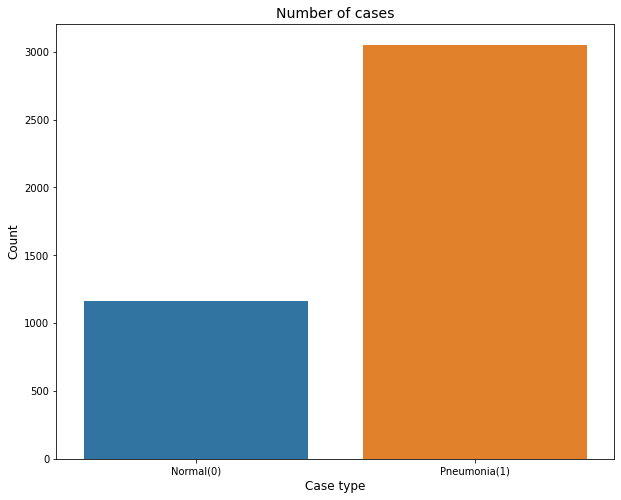

In [ ]:
plotData(config.TRAIN_PATH)

1    873
0    299
Name: label, dtype: int64


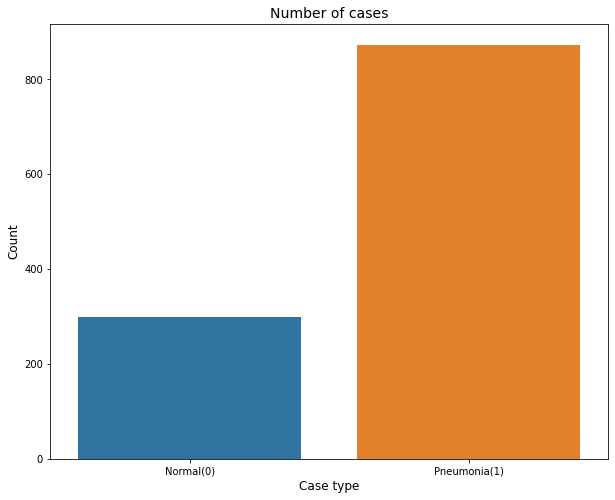

In [ ]:
plotData(config.TEST_PATH)

1    348
0    120
Name: label, dtype: int64


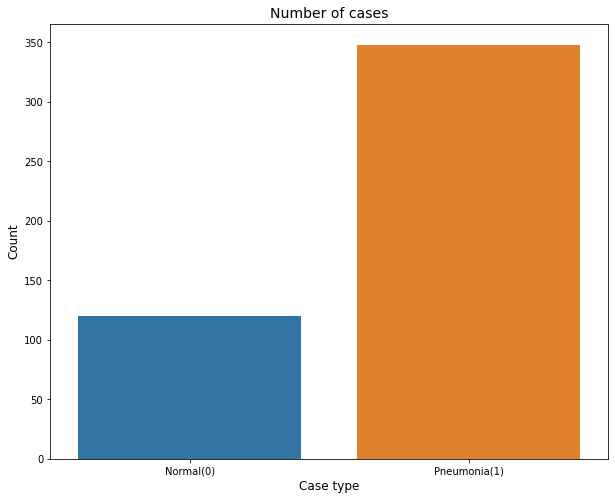

In [ ]:
plotData(config.VAL_PATH)

In [ ]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = config.TRAIN_PATH + '/0/'
pneumonia_cases_dir = config.TRAIN_PATH + '/1/'

# Get the list of all the images
normal_cases = glob.glob(normal_cases_dir + '*.jpeg')
pneumonia_cases = glob.glob(pneumonia_cases_dir + '*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data1 = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data1.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data1.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data1 = pd.DataFrame(train_data1, columns=['image', 'label'],index=None)

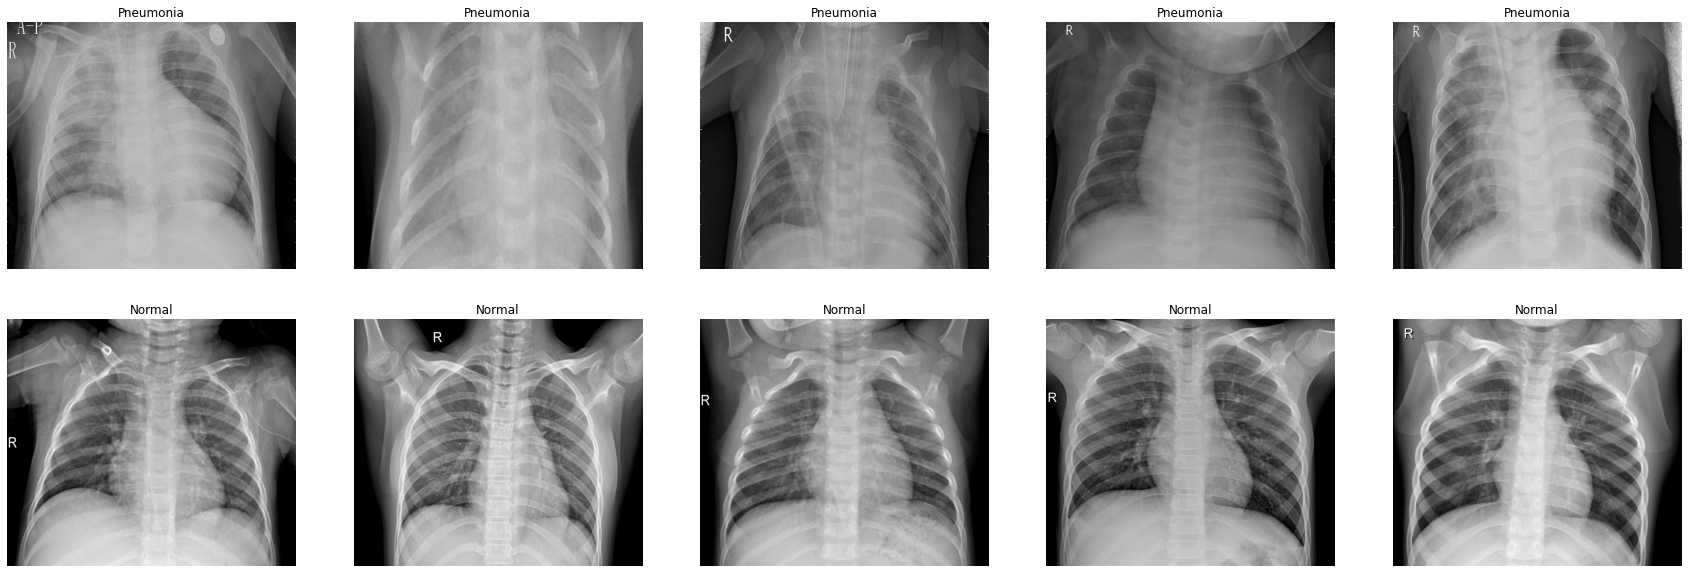

In [ ]:
# Get few samples for both the classes
pneumonia_samples = (train_data1[train_data1['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data1[train_data1['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

If we look carefully, then there are some cases where we won't be able to differentiate between a normal case and a pneumonia case with the naked eye. If we can build a robust classifier, it would be a great assist for the doctor too.

In [ ]:
# Defining a method to get the number of files given a path
def retrieveNumberOfFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.jpeg', recursive=True):
        list1.append(file_name)
    return len(list1)

In [ ]:
# Defining a method to plot training and validation accuracy and loss
def training_plot(H, N, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [ ]:
# Checking for the total number of image paths in training, validation and testing directories
totalTrain = retrieveNumberOfFiles(config.TRAIN_PATH)
totalVal = retrieveNumberOfFiles(config.VAL_PATH)
totalTest = retrieveNumberOfFiles(config.TEST_PATH)

In [ ]:
# Defining a method to get the number of files given a path
def getAllFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.jpeg', recursive=True):
        list1.append(file_name)
    return list1

In [ ]:
# Retrieving all files from train directory
allTrainFiles = getAllFiles(config.TRAIN_PATH)

In [ ]:
# Calculating the total number of training images against each class and then store the class weights in a dictionary
trainLabels = [int(p.split(os.path.sep)[-2]) for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()

# Looping over all classes and calculate the class weights
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

In [ ]:
# Initialize the training data augmentation object
## preprocess_input will scale input pixels between -1 and 1
## rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
## zoom_range is for randomly zooming inside pictures
## width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
## shear_range is for randomly applying shearing transformations
## horizontal_flip and vertical_flip is for randomly flipping half of the images horizontally and vertically resp
## fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift

trainAug = ImageDataGenerator(
	preprocessing_function=preprocess_input,
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

In [ ]:
# Initialize the validation data augmentation object
valAug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
	config.TRAIN_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=config.BATCH_SIZE)

Found 4216 images belonging to 2 classes.


In [ ]:
# Initialize the validation generator
valGen = valAug.flow_from_directory(
	config.VAL_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BATCH_SIZE)

Found 468 images belonging to 2 classes.


In [ ]:
# Initialize the testing generator
testGen = valAug.flow_from_directory(
	config.TEST_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BATCH_SIZE)

Found 1172 images belonging to 2 classes.


In [ ]:
# Loading the MobileNetV2, ensuring the head Full Connected layers are left off / removed
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

2022-01-24 11:25:42.820834: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-24 11:25:42.852324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 11:25:42.852542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.569GHz coreCount: 5 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-01-24 11:25:42.852767: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-24 11:25:42.854087: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-24 11:25:42.855370: I tensorflow/stream_executor/platform/de

In [ ]:
# Construct the head of the model that will be placed on top of the the base model
## Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
## We flatten the output of the convolutional layers to create a single long feature vector. 
### Average pooling computes the average of the elements present in the region of feature map covered by the filter.
#### ReLU stands for Rectified Linear Unit. 
#### The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time.
## Dropout is a technique where randomly selected neurons are ignored during training.

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(config.CLASSES), activation="softmax")(headModel)

In [ ]:
# Placing the head model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# Loop over all the layers of the base model and freeze them so that they are 
# not updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# Compiling the model
## Decay updates the learning rate by a decreasing factor in each epoch
print("Compiling model")
opt = Adam(lr=config.INIT_LR, decay=config.INIT_LR / config.EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling model


In [ ]:
# Using ModelCheckpoint to store the best performing model based on val_loss
MCName = os.path.sep.join([config.outputPath, "weights-{epoch:03d}-{val_loss:.4f}.hdf5"])
checkpoint = ModelCheckpoint(MCName, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [ ]:
# Fitting the model on training data
print("Model Fitting")
MF = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // config.BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalVal // config.BATCH_SIZE,
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=config.EPOCHS)

Model Fitting
Epoch 1/20


2022-01-24 11:25:47.704738: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-24 11:25:48.059436: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


  2/263 [..............................] - ETA: 6s - loss: 1.5875 - accuracy: 0.6250

2022-01-24 11:25:49.002008: W tensorflow/core/common_runtime/bfc_allocator.cc:311] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


263/263 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.8198
Epoch 00001: val_loss improved from inf to 0.38510, saving model to /home/jaydeep/Machine_Learning_Projects/Deep_Learning_Projects/chest-xray-pneumonia_2/output/weights-001-0.3851.hdf5
263/263 [==============================] - 84s 318ms/step - loss: 0.5859 - accuracy: 0.8198 - val_loss: 0.3851 - val_accuracy: 0.8319
Epoch 2/20
263/263 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.8805
Epoch 00002: val_loss improved from 0.38510 to 0.25948, saving model to /home/jaydeep/Machine_Learning_Projects/Deep_Learning_Projects/chest-xray-pneumonia_2/output/weights-002-0.2595.hdf5
263/263 [==============================] - 79s 299ms/step - loss: 0.4167 - accuracy: 0.8805 - val_loss: 0.2595 - val_accuracy: 0.8836
Epoch 3/20
263/263 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.9012
Epoch 00003: val_loss did not improve from 0.25948
263/263 [=====================

In [ ]:
# Loading the best performing model
# Please specify the model name from the output folder which has the lowest val_loss
path1 = config.outputPath + '/MN_16_weights-016-0.2087.hdf5'
fModel = load_model(path1)

In [ ]:
# Predicting on the test data
# The numpy.argmax() function returns indices of the max element of the array in a particular axis.
print("Predicting on the test data")
predTest = fModel.predict(x=testGen, steps=(totalTest // config.BATCH_SIZE) + 1)
predTest = np.argmax(predTest, axis=1)

Predicting on the test data


In [ ]:
# Printing the Classification Report
print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       299
           1       0.98      0.92      0.95       873

    accuracy                           0.92      1172
   macro avg       0.89      0.93      0.91      1172
weighted avg       0.93      0.92      0.93      1172



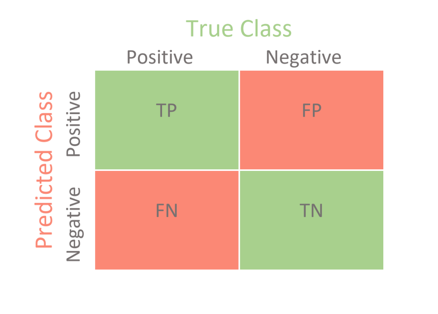

In [ ]:
# Computing the confusion matrix and and using the same to derive the 
# accuracy, sensitivity, and specificity
# Accuracy = TP + TN / TP + TN + FP + FN
# Sensitivity = TP / TP + FN
# Specificity = TN / FP + TN
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Printing the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[283  16]
 [ 72 801]]
acc: 0.9249
sensitivity: 0.9465
specificity: 0.9175


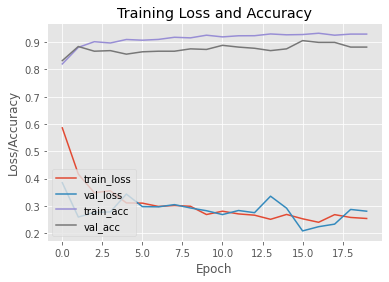

In [ ]:
# Plotting the graph
training_plot(MF, config.EPOCHS, config.PLOT_PATH)

In [ ]:
# Serialize/Writing the model to disk
print("Serializing network...")
fModel.save(config.MODEL_PATH, save_format="h5")

Serializing network...
